In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**AI-GENERATED IMAGE DETECTION**

# **Phase 1: Dataset Setup & Preprocessing**

> **Part 1: Imports & Path Setup**

In [1]:
# 📦 Step 1: Import necessary libraries
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 🛠 Step 2: Config - change image size and batch size as needed
IMG_SIZE = 224  # Resize all images to 224x224
BATCH_SIZE = 32

# 📁 Step 3: Path to the dataset
DATA_DIR = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images"

# 🧾 Step 4: Verify the dataset folders
print("Train folders:", os.listdir(os.path.join(DATA_DIR, "train")))
print("Test folders:", os.listdir(os.path.join(DATA_DIR, "test")))

Train folders: ['FAKE', 'REAL']
Test folders: ['FAKE', 'REAL']


What this part does:


* Imports required libraries.
* Sets the image size, batch size, and data path.
* Verifies the dataset structure.

> **Part 2: Image Transformations (Preprocessing)**

In [2]:
from torchvision import transforms

# 🎨 Define transforms for training with augmentation
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# 🧼 Define transforms for testing (no augmentation)
test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

What this part does:


* Applies augmentation to training images (flip, rotate, color jitter).
* Applies normalization to both train & test sets.
* Prepares transformations for the dataset.

> **Part 3: Load Train & Test Dataset with Transforms**

In [3]:
from torchvision import datasets

# 📂 Load training dataset
from PIL import Image, UnidentifiedImageError

# Force all images to RGB mode (avoids warnings from transparency)
# If the image is corrupt (truncated / unreadable), it prints the path and replaces it with a plain black dummy image so training won’t crash.
def pil_loader_rgb(path):
    try:
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')
    except (OSError, UnidentifiedImageError) as e:
        print(f"[Skipped broken image] {path} — {e}")
        return Image.new("RGB", (IMG_SIZE, IMG_SIZE), (0, 0, 0))  # black dummy image

train_dataset = datasets.ImageFolder(
    root=os.path.join(DATA_DIR, "train"),
    transform=train_transforms,
    loader=pil_loader_rgb
)

test_dataset = datasets.ImageFolder(
    root=os.path.join(DATA_DIR, "test"),
    transform=test_transforms,
    loader=pil_loader_rgb
)

# 🏷️ Print class labels
print("Class labels:", train_dataset.classes)

Class labels: ['FAKE', 'REAL']


What this part does:


* Loads images using ImageFolder from the correct folders.
* Applies the correct transform (with/without augmentation).
* Prepares the dataset object.

> **Part 4: Create Train & Test DataLoaders**

In [4]:
from torch.utils.data import DataLoader

# 🔁 Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# ✅ Check DataLoader sample
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of testing batches: {len(test_loader)}")

Number of training batches: 3125
Number of testing batches: 625


What this part does:

* Wraps the datasets in PyTorch DataLoader.
* Allows batching, shuffling, and efficient loading during training.

> **Part 5: Visualize some training images**

In [ ]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

from PIL import Image
Image.MAX_IMAGE_PIXELS = None  # disables the decompression bomb warning

# 📸 Unnormalize and display
def imshow(img):
    img = img / 2 + 0.5  # Undo normalization
    npimg = img.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(10, 5))
    plt.imshow(npimg)
    plt.axis("off")
    plt.show()

# 🔁 Get one batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 🖼️ Display 8 images in a row
imshow(torchvision.utils.make_grid(images[:8]))
print("Labels:", [train_dataset.classes[label] for label in labels[:8]])

What this part does:

* Visualizes some of the sample images from the training set

# **Phase 2: Model Building & Training**

**RESNET18**

> **Part 1: Define the CNN Model (ResNet18)**

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet18_Weights

# ✅ Use updated way to load pretrained ResNet18
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# 🔁 Replace the last fully connected layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 output classes: fake & real

# 🚀 Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("Model loaded ✅ — using device:", device)

What this part does:

* Loads a pretrained ResNet18 model from torchvision.models
* Replaces the final layer to output 2 classes: ['fake', 'real']

> **Part 2: Setup Training Tools**

In [ ]:
import torch.optim as optim

# 📉 Loss Function - perfect for classification
criterion = nn.CrossEntropyLoss()

# 🧠 Optimizer - Adam is great for deep learning
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 📉 Learning Rate Scheduler - reduce LR if stuck
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',            # Minimize validation loss
    factor=0.5,            # Reduce LR by half
    patience=2            # Wait for 2 epochs before reducing
)

What this part does:

Defines how the model learns-
* Loss function → How wrong was the prediction?
* Optimizer → How to update weights?
* Scheduler → Adjusts learning rate over epochs.

> **Part 3: Model Training & Validation**

In [ ]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("Current device:", device)
print("Model is on:", next(model.parameters()).device)

In [ ]:
EPOCHS = 10  # or more
CHECKPOINT_INTERVAL = 1000  # images
PRINT_INTERVAL = 15  # batches

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    images_seen = 0  # 👈 Tracks how many images passed

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        images_seen += labels.size(0)

        # ✅ Print progress every PRINT_INTERVAL batches
        if (i + 1) % PRINT_INTERVAL == 0:
            print(f"Epoch {epoch+1}, Batch {i+1}, Processed {images_seen} images...")

        # 💾 Save checkpoint every CHECKPOINT_INTERVAL images
        if images_seen >= CHECKPOINT_INTERVAL:
            ckpt_path = f"checkpoint_epoch{epoch+1}_img{images_seen}.pth"
            optimizer_ckpt_path = f"optimizer_epoch{epoch+1}_img{images_seen}.pth"
            
            torch.save(model.state_dict(), ckpt_path)
            torch.save(optimizer.state_dict(), optimizer_ckpt_path)  # ✅ Save optimizer state

            print(f"💾 Checkpoint saved at {ckpt_path}")
            print(f"💾 Optimizer checkpoint saved at {optimizer_ckpt_path}")

            images_seen = 0  # Reset counter for next checkpoint

    # ✅ Epoch summary
    train_acc = 100 * correct / total
    avg_train_loss = running_loss / len(train_loader)

    # 🔍 Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(test_loader)
    scheduler.step(avg_val_loss)

    print(f"📊 Epoch [{epoch+1}/{EPOCHS}]")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val   Loss: {avg_val_loss:.4f}, Val   Acc: {val_acc:.2f}%")
    print("-" * 50)

# 🔚 Final save
torch.save(model.state_dict(), f"resnet18_final_acc_{val_acc:.2f}.pth")
torch.save(optimizer.state_dict(), "optimizer_final.pth")  # ✅ Save final optimizer state
print("✅ Final model and optimizer saved.")


What this part does:

* Runs training over multiple epochs
* Tracks training + validation loss and accuracy
* Updates model weights + adjusts learning rate

In [ ]:
# 🔁 Resume training from checkpoint (Epoch 3)
import torch

EPOCHS = 10  # or more
CHECKPOINT_INTERVAL = 1000  # images
PRINT_INTERVAL = 15  # batches

# 📍 Specify your checkpoint paths
model_ckpt_path = "/kaggle/input/tdl-epoch-8/checkpoint_epoch8_img1024 (1).pth"
optimizer_ckpt_path = "/kaggle/input/tdl-epoch-8/optimizer_epoch8_img1024 (1).pth"

# ✅ Load model state
model.load_state_dict(torch.load(model_ckpt_path))
model.to(device)
print(f"✅ Model loaded from {model_ckpt_path}")

# ✅ Load optimizer state
optimizer.load_state_dict(torch.load(optimizer_ckpt_path))
print(f"✅ Optimizer loaded from {optimizer_ckpt_path}")

# ✅ Optional: Resume scheduler if using ReduceLROnPlateau or similar
# scheduler.load_state_dict(torch.load("scheduler_epoch3.pth"))

# 🔁 Set start epoch to resume
start_epoch = 8  # Because you've completed Epoch 3

# Now continue training loop like:
for epoch in range(start_epoch, EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    images_seen = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        images_seen += labels.size(0)

        if (i + 1) % PRINT_INTERVAL == 0:
            print(f"Epoch {epoch+1}, Batch {i+1}, Processed {images_seen} images...")

        if images_seen >= CHECKPOINT_INTERVAL:
            ckpt_path = f"checkpoint_epoch{epoch+1}_img{images_seen}.pth"
            optimizer_ckpt_path = f"optimizer_epoch{epoch+1}_img{images_seen}.pth"
            
            torch.save(model.state_dict(), ckpt_path)
            torch.save(optimizer.state_dict(), optimizer_ckpt_path)

            print(f"💾 Checkpoint saved at {ckpt_path}")
            print(f"💾 Optimizer checkpoint saved at {optimizer_ckpt_path}")
            images_seen = 0

    train_acc = 100 * correct / total
    avg_train_loss = running_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(test_loader)
    scheduler.step(avg_val_loss)

    print(f"📊 Epoch [{epoch+1}/{EPOCHS}]")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val   Loss: {avg_val_loss:.4f}, Val   Acc: {val_acc:.2f}%")
    print("-" * 50)

# 🔚 Final model and optimizer save
torch.save(model.state_dict(), f"resnet18_final_acc_{val_acc:.2f}.pth")
torch.save(optimizer.state_dict(), "optimizer_final.pth")
print("✅ Final model and optimizer saved.")


What this part does:
* Used to load a previously saved model checkpoint

> **Accuracy, Precision, Recall, and F1-score Calculations**

In [ ]:
import torch

# 📍 Checkpoint paths
model_ckpt_path = "/kaggle/input/resnet-final/resnet18_final_acc_92.87.pth"
optimizer_ckpt_path = "/kaggle/input/resnet-final/optimizer_final.pth"

# ✅ Load model state dict
model.load_state_dict(torch.load(model_ckpt_path, map_location=device))
model.to(device)
print(f"✅ Model loaded from {model_ckpt_path}")

# ✅ Load optimizer state dict
optimizer.load_state_dict(torch.load(optimizer_ckpt_path, map_location=device))
print(f"✅ Optimizer loaded from {optimizer_ckpt_path}")


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# 📊 Collect predictions
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 🧾 Metrics
print("🔍 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\n📄 Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

# 🔢 Individual scores
print("✅ Accuracy:", accuracy_score(y_true, y_pred) * 100, "%")
print("🎯 Precision (macro):", precision_score(y_true, y_pred, average='macro'))
print("🔁 Recall (macro):", recall_score(y_true, y_pred, average='macro'))
print("🧠 F1-score (macro):", f1_score(y_true, y_pred, average='macro'))

What this part does:
* Helps evaluate where the model is making mistakes.
* Accuracy - Total correct predictions / total samples
* Precision - % of predicted positives that are correct
* Recall - % of actual positives correctly predicted
* F1-score - Harmonic mean of precision and recall
* Classification Report - Includes precision, recall, f1 for each class

> **Confusion Matrix Heatmap (visual)**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
class_names = train_dataset.classes

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()


> **ROC Curve & AUC (for binary classification)**

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert to binary labels if not already
y_true_bin = label_binarize(y_true, classes=[0, 1]).ravel()
y_pred_probs = []

model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of class 1
        y_pred_probs.extend(probs.cpu().numpy())

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true_bin, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


> **Per-Class Precision, Recall, F1 Breakdown**

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Display rounded values
print(report_df[['precision', 'recall', 'f1-score']].round(3))


> **Grad-CAM for Explainability**

In [ ]:
!pip install grad-cam


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.models as models

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load image
img_path = "/kaggle/input/ai-generated-images-vs-real-images/test/real/0001.jpg"
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Preprocess the image
input_tensor = preprocess_image(rgb_img.astype(np.float32) / 255.0, 
                               mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])

# Fix: The preprocess_image function should return a tensor of shape [1, 3, 224, 224]
# Let's ensure our tensor shape is correct
if input_tensor.ndim == 4 and input_tensor.shape[0] == 1 and input_tensor.shape[1] == 3:
    # Input is already batched correctly
    pass
elif input_tensor.ndim == 5:
    # Remove extra dimension
    input_tensor = input_tensor.squeeze(0)
elif input_tensor.ndim == 3:
    # Add batch dimension if needed
    input_tensor = input_tensor.unsqueeze(0)

# Print tensor shape to verify
print(f"Input tensor shape: {input_tensor.shape}")

input_tensor = input_tensor.to(device)

# Set up Grad-CAM
target_layer = model.layer4[-1]

# Initialize GradCAM
cam = GradCAM(model=model, target_layers=[target_layer])

# Make a prediction to get the class with highest probability
with torch.no_grad():
    output = model(input_tensor)
    
# Get the class index with the highest score
_, predicted_class = torch.max(output, 1)
target_class = predicted_class.item()

# Generate Grad-CAM for the predicted class
targets = [ClassifierOutputTarget(target_class)]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

# Overlay the heatmap on the original image
visualization = show_cam_on_image(rgb_img.astype(np.float32) / 255.0, grayscale_cam, use_rgb=True)

# Plot and display results
plt.figure(figsize=(12, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(rgb_img)
plt.title("Original Image")
plt.axis('off')

# Grad-CAM visualization
plt.subplot(1, 2, 2)
plt.imshow(visualization)
plt.title(f"Grad-CAM Heatmap (Class: {target_class})")
plt.axis('off')

plt.tight_layout()
plt.show()

# Print the predicted class
print(f"Predicted class: {target_class}")

> **Robustness Testing**

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.transforms import functional as TF
from PIL import Image, ImageFilter, ImageEnhance
import io
import random
import numpy as np
from sklearn.metrics import accuracy_score

# Define corruption functions
def add_gaussian_noise(img, mean=0, std=0.1):
    """Add Gaussian noise to a tensor image"""
    noise = torch.randn(img.size()) * std + mean
    noisy_img = img + noise
    return torch.clamp(noisy_img, 0., 1.)  # Already returns a tensor

def compress_jpeg(img, quality=20):
    """Compress a PIL image using JPEG compression"""
    buf = io.BytesIO()
    img.save(buf, format='JPEG', quality=quality)
    buf.seek(0)
    return Image.open(buf)  # Returns a PIL Image

def random_rotate(img, degrees=15):
    """Rotate a PIL image by a random angle"""
    return TF.rotate(img, random.uniform(-degrees, degrees))  # Returns a PIL Image


> **Evaluate on Corrupted Test Set**

In [ ]:

# Set model to evaluation mode
model.eval()

# Define corruption types
corrupt_types = ['jpeg', 'noise', 'rotate']
results = {}

# Run robustness testing
with torch.no_grad():
    for corrupt in corrupt_types:
        y_true, y_pred = [], []
        for images, labels in test_loader:
            corrupted_images = []
            for img in images:
                if corrupt == 'jpeg':
                    # Convert to PIL, apply corruption, then back to tensor
                    pil_img = TF.to_pil_image(img.cpu())
                    corrupted = compress_jpeg(pil_img)
                    corrupted = TF.to_tensor(corrupted)
                elif corrupt == 'noise':
                    # Already returns a tensor, no need to convert back
                    corrupted = add_gaussian_noise(img.cpu())
                elif corrupt == 'rotate':
                    # Convert to PIL, apply corruption, then back to tensor
                    pil_img = TF.to_pil_image(img.cpu())
                    corrupted = random_rotate(pil_img)
                    corrupted = TF.to_tensor(corrupted)
                else:
                    corrupted = img
                
                corrupted_images.append(corrupted)
            
            batch = torch.stack(corrupted_images).to(device)
            outputs = model(batch)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
        
        acc = accuracy_score(y_true, y_pred)
        results[corrupt] = acc
        print(f"Robustness - {corrupt}: Accuracy = {acc * 100:.2f}%")

# Visualize results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(results.keys(), [val * 100 for val in results.values()], color='skyblue')
plt.axhline(y=100, color='r', linestyle='--', alpha=0.5)
plt.ylabel('Accuracy (%)')
plt.title('Model Robustness Against Different Corruptions')
plt.ylim(0, 100)

for i, v in enumerate(results.values()):
    plt.text(i, v * 100 + 2, f"{v * 100:.1f}%", ha='center')

plt.tight_layout()
plt.show()

> **Summary Table**

In [ ]:
import pandas as pd

df = pd.DataFrame(list(results.items()), columns=["Corruption", "Accuracy"])
df.sort_values("Accuracy", ascending=False).reset_index(drop=True)


# **PHASE 3: TESTING ON ANOTHER DATASET**

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch.nn as nn
import numpy as np

# 🔧 Device Setup
device = "cuda" if torch.cuda.is_available() else "cpu"

# 📦 Transform (Same as during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# 📂 Load Test Dataset
test_dataset = datasets.ImageFolder(
    root="/kaggle/input/ai-generated-images-vs-real-images/test",
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ✅ Model Architecture (Replace if you used something else)
class MyCNNModel(nn.Module):
    def __init__(self):
        super(MyCNNModel, self).__init__()
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, 2)

    def forward(self, x):
        return self.model(x)

# 🔁 Load Trained Model
model = MyCNNModel()
model.load_state_dict(torch.load("/kaggle/working/model.pth"))  # 🔁 Use your correct model path
model.to(device)
model.eval()

# 📊 Evaluate
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 📈 Compute Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

# 🖨️ Results
print("📊 Evaluation Results on AI-vs-Real Dataset:")
print(f"✅ Accuracy:  {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall:    {recall:.4f}")
print(f"✅ F1 Score:  {f1:.4f}")
print("🧩 Confusion Matrix:")
print(conf_matrix)


In [62]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from PIL import ImageFile
import os

# Fix for truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Define transforms for test data
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ResNet standard input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                         std=[0.229, 0.224, 0.225])
])

# 2. Load test dataset
test_dir = "/kaggle/input/ai-generated-images-vs-real-images/test"
test_dataset = ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 3. Load your trained ResNet18 model
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)  # For binary classification
model.load_state_dict(torch.load("/kaggle/input/oooooo/resnet18_final_acc_98.03.pth", map_location=device))
model.to(device)
model.eval()

# 4. Evaluate model
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 5. Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

# 6. Print results
print("📊 Evaluation Results on AI-vs-Real Dataset:")
print(f"✅ Accuracy:  {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall:    {recall:.4f}")
print(f"✅ F1 Score:  {f1:.4f}")
print("🧩 Confusion Matrix:")
print(conf_matrix)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-62-608d5d1bd06e>:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

📊 Evaluation Results on AI-vs-Real Dataset:
✅ Accuracy:  0.5835
✅ Precision: 0.6506
✅ Recall:    0.3607
✅ F1 Score:  0.4641
🧩 Confusion Matrix:
[[4838 1162]
 [3836 2164]]


In [22]:
import torch
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from PIL import ImageFile
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

ImageFile.LOAD_TRUNCATED_IMAGES = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 1. Load Test Dataset ===
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust if models need different sizes
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_dataset = datasets.ImageFolder("/kaggle/input/ai-generated-images-vs-real-images/test", transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# === 2. Load Models ===
# Assuming all models output logits or softmax
def load_model(path, model_arch):
    model = model_arch()
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Replace with your actual model definitions
from torchvision.models import resnet18
def get_resnet():
    m = resnet18(pretrained=False)
    m.fc = torch.nn.Linear(m.fc.in_features, 2)
    return m

# For GAN discriminators adapted to classification
# Just placeholders - plug in your actual ones
def get_dcgan(): return YourDCGANClassifier()
def get_icgan(): return YourICGANClassifier()
def get_stylegan(): return YourStyleGANClassifier()

resnet = load_model("/kaggle/input/oooooo/resnet18_final_acc_98.03.pth", get_resnet)
dcgan = load_model("/kaggle/input/finetunedgans/finetuned_discriminator_cifake.pth", get_dcgan)
icgan = load_model("/kaggle/input/finetunedgans/cifake_discriminator_icgan_finetuned.pth", get_icgan)
stylegan = load_model("/kaggle/input/finetunedgans/finetuned_stylegan_discriminator_cifake.pth", get_stylegan)

models = [resnet, dcgan, icgan, stylegan]

# === 3. Ensemble Inference ===
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        all_model_probs = []

        for model in models:
            logits = model(images)
            probs = F.softmax(logits, dim=1)  # [batch_size, 2]
            all_model_probs.append(probs)

        # Soft voting: average probabilities
        avg_probs = torch.stack(all_model_probs).mean(dim=0)  # [batch_size, 2]
        preds = torch.argmax(avg_probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# === 4. Metrics ===
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

# === 5. Print Results ===
print("📊 Evaluation Results on AI-vs-Real Ensemble:")
print(f"✅ Accuracy:  {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall:    {recall:.4f}")
print(f"✅ F1 Score:  {f1:.4f}")
print("🧩 Confusion Matrix:")
print(conf_matrix)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-22-db221d46d265>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

NameError: name 'YourDCGANClassifier' is not defined

# **PHASE 4: COMBINING ICGAN+DCGAN**

In [5]:
# 📦 Imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from torchvision import transforms
from PIL import Image
from sklearn.metrics import accuracy_score, classification_report

# 🚀 Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [11]:
# ⚙️ Image Dataset
class FlatImageFolder(Dataset):
    def __init__(self, root_dir, label, transform=None):
        self.paths = sorted(
            os.path.join(root_dir, f)
            for f in os.listdir(root_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        )
        self.transform = transform
        self.label = label

    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        if self.transform: img = self.transform(img)
        return img, self.label

# 🧪 Test Set
image_size = 32
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

real_test_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/REAL"
fake_test_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/FAKE"

real_ds = FlatImageFolder(real_test_dir, label=1, transform=transform)
fake_ds = FlatImageFolder(fake_test_dir, label=0, transform=transform)

test_loader = DataLoader(
    ConcatDataset([real_ds, fake_ds]),
    batch_size=64, shuffle=False, num_workers=2
)


In [7]:
# 🧠 ICGAN Discriminator
class ICGANDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.final = nn.Conv2d(128, 256, 4, 1, 0)
        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.final(x)
        return self.output(x).view(-1)

# 🧠 DCGAN Discriminator
class DCGANDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        nc, ndf = 3, 64
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1)


In [8]:
model_icgan = ICGANDiscriminator().to(device)
model_dcgan = DCGANDiscriminator().to(device)

model_icgan.load_state_dict(torch.load("/kaggle/input/finetunedgans/cifake_discriminator_icgan_finetuned.pth", map_location=device))
model_dcgan.load_state_dict(torch.load("/kaggle/input/finetunedgans/finetuned_discriminator_cifake.pth", map_location=device))

model_icgan.eval()
model_dcgan.eval()


<ipython-input-8-a625a77b607d>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_icgan.load_state_dict(torch.load("/kaggle/input/finetunedgans/cifake_discriminator_icga

DCGANDiscriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

In [7]:
# 🏷️ Get all true labels
all_labels = []
for _, labels in test_loader:
    all_labels.extend(labels.numpy())

# 🔁 Tune ICGAN vs DCGAN weights
best_acc = 0
best_weight = 0

for alpha in [i / 100 for i in range(50, 100, 5)]:
    all_preds = []
    for images, _ in test_loader:
        images = images.to(device)

        with torch.no_grad():
            p1 = model_icgan(images)
            p2 = model_dcgan(images)
            avg_probs = (alpha * p1 + (1 - alpha) * p2)
            preds = (avg_probs > 0.5).long()
            all_preds.extend(preds.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"🔁 Weight ICGAN: {alpha:.2f} | Accuracy: {acc:.4f}")

    if acc > best_acc:
        best_acc = acc
        best_weight = alpha

print(f"\\n🚀 Best Accuracy: {best_acc:.4f} at ICGAN Weight = {best_weight:.2f}")


🔁 Weight ICGAN: 0.50 | Accuracy: 0.9540


KeyboardInterrupt: 

In [ ]:
final_preds = []
for images, _ in test_loader:
    images = images.to(device)
    with torch.no_grad():
        p1 = model_icgan(images)
        p2 = model_dcgan(images)
        avg_probs = (best_weight * p1 + (1 - best_weight) * p2)
        preds = (avg_probs > 0.5).long()
        final_preds.extend(preds.cpu().numpy())

print("\\n📊 Final Report after Combining ICGAN + DCGAN:")
print(classification_report(all_labels, final_preds))


# **PHASE 5: COMBINING ICGAN+DCGAN+STYLEGAN**

✅ Using device: cuda
✅ StyleGAN loaded.
Missing keys: []
Unexpected keys: []


<ipython-input-9-1e34e8e89ed1>:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw_state = torch.load(ckpt, map_location=device)
/usr/local/lib/python3.10/dist-packages/PI


🧪 Final Evaluation for ICGAN + DCGAN + StyleGAN
✅ Accuracy: 50.70%
📊 Confusion Matrix:
[[ 335 5665]
 [ 251 5749]]
📋 Classification Report:
              precision    recall  f1-score   support

        Fake       0.57      0.06      0.10      6000
        Real       0.50      0.96      0.66      6000

    accuracy                           0.51     12000
   macro avg       0.54      0.51      0.38     12000
weighted avg       0.54      0.51      0.38     12000

📈 ROC-AUC Score: 0.4925


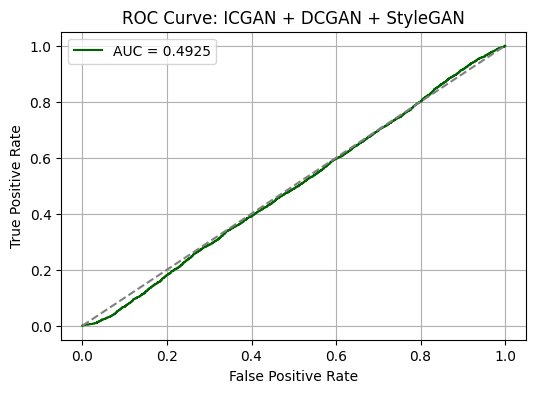

In [9]:
# === 1. Imports ===
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
)

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


# === 2. Device & Reproducibility ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
print("✅ Using device:", device)


# === 3. StyleGAN Discriminator Definition ===
class EqualizedLinear(nn.Module):
    def __init__(self, in_f, out_f, gain=1.0):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_f, in_f).div_(gain))
        self.bias   = nn.Parameter(torch.zeros(out_f))
    def forward(self, x):
        return F.linear(x, self.weight, self.bias)

class EqualizedConv2d(nn.Module):
    def __init__(self, in_ch, out_ch, k, stride=1, pad=0):
        super().__init__()
        conv = nn.Conv2d(in_ch, out_ch, k, stride, pad)
        scale = 1/np.sqrt(in_ch * k * k)
        nn.init.normal_(conv.weight, 0.0, 1.0)
        conv.weight.data.mul_(scale)
        nn.init.zeros_(conv.bias)
        self.conv = conv
    def forward(self, x):
        return self.conv(x)

class MinibatchStdDev(nn.Module):
    def __init__(self, group_size=4):
        super().__init__()
        self.group_size = group_size
    def forward(self, x):
        bs, ch, h, w = x.shape
        g = min(self.group_size, bs)
        if g <= 1:
            return torch.cat([x, torch.zeros(bs, 1, h, w, device=x.device)], dim=1)
        n = bs // g
        y = x.view(g, n, ch, h, w)
        y = y.std(dim=0, unbiased=False).mean(dim=1, keepdim=True)
        y = y.repeat(g, 1, 1, 1)[:bs]
        return torch.cat([x, y], dim=1)

class StyleGANDiscriminator(nn.Module):
    def __init__(self, channels=32):
        super().__init__()
        self.from_rgb = EqualizedConv2d(3, channels, 1)
        self.features = nn.ModuleList([
            nn.Sequential(EqualizedConv2d(channels,   channels*2, 4, 2, 1), nn.LeakyReLU(0.2)),
            nn.Sequential(EqualizedConv2d(channels*2, channels*4, 4, 2, 1), nn.LeakyReLU(0.2)),
            nn.Sequential(EqualizedConv2d(channels*4, channels*8, 4, 2, 1), nn.LeakyReLU(0.2)),
        ])
        self.final_block = nn.Sequential(
            MinibatchStdDev(),
            EqualizedConv2d(channels*8 + 1, channels*8, 3, 1, 1),
            nn.LeakyReLU(0.2),
            EqualizedConv2d(channels*8, channels*4, 4, 1, 0),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            EqualizedLinear(channels*4, 1)
        )

    def forward(self, x):
        x = self.from_rgb(x)
        for block in self.features:
            x = block(x)
        return self.final_block(x).view(-1)


# === 4. StyleGAN Load Checkpoint ===
model_stylegan = StyleGANDiscriminator().to(device)
ckpt = "/kaggle/input/finetunedgans/finetuned_stylegan_discriminator_cifake.pth"
raw_state = torch.load(ckpt, map_location=device)

# Fix keys
fixed_state = {}
for k, v in raw_state.items():
    if k.startswith("final_block.6.linear"):
        fixed_state[k.replace("final_block.6.linear", "final_block.6")] = v
    else:
        fixed_state[k] = v

missing, unexpected = model_stylegan.load_state_dict(fixed_state, strict=False)
print("✅ StyleGAN loaded.")
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)
model_stylegan.eval()


# === 5. Final 3-model Ensemble Evaluation Function ===
def evaluate_three_model_ensemble(model1, model2, model3, loader, alpha=0.33, beta=0.33, name="ICGAN + DCGAN + StyleGAN"):
    all_labels, all_probs, all_preds = [], [], []
    model1.eval()
    model2.eval()
    model3.eval()

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            p1 = model1(images).view(-1)
            p2 = model2(images).view(-1)
            p3 = model3(images).view(-1)

            combined = (alpha * p1 + beta * p2 + (1 - alpha - beta) * p3).cpu().numpy()
            pred_labels = (combined >= 0.5).astype(int)

            all_probs.extend(combined)
            all_preds.extend(pred_labels)
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=["Fake", "Real"])
    auc = roc_auc_score(all_labels, all_probs)

    print(f"\n🧪 Final Evaluation for {name}")
    print(f"✅ Accuracy: {acc * 100:.2f}%")
    print(f"📊 Confusion Matrix:\n{cm}")
    print(f"📋 Classification Report:\n{cr}")
    print(f"📈 ROC-AUC Score: {auc:.4f}")

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color="darkgreen")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f"ROC Curve: {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()


# === 6. Run Final Evaluation ===
evaluate_three_model_ensemble(
    model_icgan,           # already loaded earlier
    model_dcgan,           # already loaded earlier
    model_stylegan,        # just defined
    test_loader,           # already built
    alpha=0.33,
    beta=0.33,
    name="ICGAN + DCGAN + StyleGAN"
)


# **PHASE 6 ICGAN+DCGAN+STYLEGAN+RESNET**

In [12]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet18_Weights

# ✅ Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Load pretrained ResNet18 base
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# 🔁 Replace final fully connected layer for binary classification (fake vs real)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# 🚀 Move model to device
model = model.to(device)

# 📍 Checkpoint paths
model_ckpt_path = "/kaggle/input/oooooo/resnet18_final_acc_98.03.pth"
#optimizer_ckpt_path = "/kaggle/input/oooooo/optimizer_final.pth"

# ✅ Load model weights
model.load_state_dict(torch.load(model_ckpt_path, map_location=device))
print(f"✅ ResNet18 model loaded from {model_ckpt_path}")

""" ✅ If you want the optimizer too (optional)
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.0001)
optimizer.load_state_dict(torch.load(optimizer_ckpt_path, map_location=device))
print(f"✅ Optimizer loaded from {optimizer_ckpt_path}")"""

# Set model to evaluation mode
model.eval()


✅ ResNet18 model loaded from /kaggle/input/oooooo/resnet18_final_acc_98.03.pth


<ipython-input-12-91d78b201ac5>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_ckpt_path, map_location=device))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
def evaluate_four_model_ensemble(model1, model2, model3, model4, loader,
                                 alpha=0.25, beta=0.25, gamma=0.25,
                                 name="ICGAN + DCGAN + StyleGAN + ResNet"):
    all_labels, all_probs, all_preds = [], [], []
    model1.eval()
    model2.eval()
    model3.eval()
    model4.eval()

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            p1 = model1(images).view(-1)                         # ICGAN
            p2 = model2(images).view(-1)                         # DCGAN
            p3 = model3(images).view(-1)                         # StyleGAN
            p4_raw = model4(images)                              # ResNet
            p4 = torch.softmax(p4_raw, dim=1)[:, 1]              # Prob(Real class)

            combined = (alpha * p1 + beta * p2 + gamma * p3 + (1 - alpha - beta - gamma) * p4).cpu().numpy()
            pred_labels = (combined >= 0.5).astype(int)

            all_probs.extend(combined)
            all_preds.extend(pred_labels)
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=["Fake", "Real"])
    auc = roc_auc_score(all_labels, all_probs)

    print(f"\n🧪 Final Evaluation for {name}")
    print(f"✅ Accuracy: {acc * 100:.2f}%")
    print(f"📊 Confusion Matrix:\n{cm}")
    print(f"📋 Classification Report:\n{cr}")
    print(f"📈 ROC-AUC Score: {auc:.4f}")

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color="darkblue")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f"ROC Curve: {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()


In [11]:
evaluate_four_model_ensemble(
    model_icgan,           # ICGAN
    model_dcgan,           # DCGAN
    model_stylegan,        # StyleGAN
    model,                 # ResNet18
    test_loader,           # Your test DataLoader
    alpha=0.25,
    beta=0.25,
    gamma=0.25,
    name="ICGAN + DCGAN + StyleGAN + ResNet18"
)


TypeError: evaluate_four_model_ensemble() got an unexpected keyword argument 'alpha'

# 3 GANS +  RES OPTIMIZED CODE

In [10]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# ----------------------------------------------
# 🔍 Find best threshold for classification
# ----------------------------------------------
def find_best_threshold(labels, probs):
    best_thresh = 0.5
    best_acc = 0
    for t in np.arange(0.3, 0.71, 0.01):
        preds = (np.array(probs) >= t).astype(int)
        acc = accuracy_score(labels, preds)
        if acc > best_acc:
            best_acc = acc
            best_thresh = t
    return best_thresh

# ----------------------------------------------
# 🔧 Grid search for best ensemble weights
# ----------------------------------------------
def optimize_weights(models, loader, search_step=0.1):
    best_acc = 0
    best_weights = (0.25, 0.25, 0.25)
    for a in np.arange(0, 1 + search_step, search_step):
        for b in np.arange(0, 1 - a + search_step, search_step):
            for g in np.arange(0, 1 - a - b + search_step, search_step):
                d = 1 - a - b - g
                if d < 0: continue
                acc = evaluate_ensemble_once(*models, loader, a, b, g, silent=True)
                if acc > best_acc:
                    best_acc = acc
                    best_weights = (a, b, g)
    return best_weights

def evaluate_ensemble_once(model1, model2, model3, model4, loader,
                           alpha, beta, gamma, silent=False):
    all_labels, all_preds = [], []
    model1.eval()
    model2.eval()
    model3.eval()
    model4.eval()

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            p1 = model1(images).view(-1)
            p2 = model2(images).view(-1)
            p3 = model3(images).view(-1)
            p4 = torch.softmax(model4(images), dim=1)[:, 1]

            combined = (alpha * p1 + beta * p2 + gamma * p3 + (1 - alpha - beta - gamma) * p4).cpu().numpy()
            pred_labels = (combined >= 0.5).astype(int)

            all_preds.extend(pred_labels)
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    return acc

# ----------------------------------------------
# 🚀 Final ensemble evaluation with optimization
# ----------------------------------------------
def evaluate_four_model_ensemble(model1, model2, model3, model4, loader,
                                 name="ICGAN + DCGAN + StyleGAN + ResNet"):
    print("🔍 Optimizing ensemble weights...")
    best_alpha, best_beta, best_gamma = optimize_weights(
        (model1, model2, model3, model4), loader, search_step=0.1
    )
    print(f"✅ Best weights found: α={best_alpha}, β={best_beta}, γ={best_gamma}, δ={1 - best_alpha - best_beta - best_gamma}")

    all_labels, all_probs, all_preds = [], [], []
    model1.eval()
    model2.eval()
    model3.eval()
    model4.eval()

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            p1 = model1(images).view(-1)
            p2 = model2(images).view(-1)
            p3 = model3(images).view(-1)
            p4 = torch.softmax(model4(images), dim=1)[:, 1]

            combined = (best_alpha * p1 + best_beta * p2 + best_gamma * p3 +
                        (1 - best_alpha - best_beta - best_gamma) * p4).cpu().numpy()

            all_probs.extend(combined)
            all_labels.extend(labels.cpu().numpy())

    # 🔍 Tune classification threshold
    best_thresh = find_best_threshold(all_labels, all_probs)
    print(f"🎯 Optimal Threshold: {best_thresh:.2f}")
    all_preds = (np.array(all_probs) >= best_thresh).astype(int)

    # 📊 Metrics
    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=["Fake", "Real"])
    auc = roc_auc_score(all_labels, all_probs)

    print(f"\n🧪 Final Evaluation for {name}")
    print(f"✅ Accuracy: {acc * 100:.2f}%")
    print(f"📊 Confusion Matrix:\n{cm}")
    print(f"📋 Classification Report:\n{cr}")
    print(f"📈 ROC-AUC Score: {auc:.4f}")

    # 📈 ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color="darkblue")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f"ROC Curve: {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()


🔍 Optimizing ensemble weights...
✅ Best weights found: α=0.30000000000000004, β=0.5, γ=0.1, δ=0.09999999999999995
🎯 Optimal Threshold: 0.53

🧪 Final Evaluation for ICGAN + DCGAN + StyleGAN + ResNet
✅ Accuracy: 97.52%
📊 Confusion Matrix:
[[9759  241]
 [ 255 9745]]
📋 Classification Report:
              precision    recall  f1-score   support

        Fake       0.97      0.98      0.98     10000
        Real       0.98      0.97      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000

📈 ROC-AUC Score: 0.9971


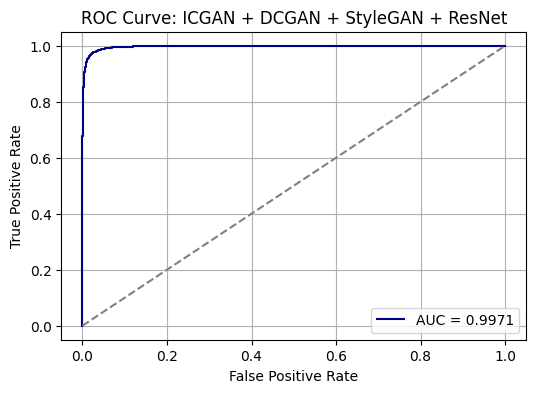

In [15]:
evaluate_four_model_ensemble(    
    model_icgan,           # ICGAN
    model_dcgan,           # DCGAN
    model_stylegan,  
    model, 
    test_loader)


# use gans. if classifies fake pass to res and use its classification

In [8]:
def classify_with_resnet_on_fake(
    model_dcgan,
    model_icgan,
    model_stylegan,
    model_resnet,
    loader,
    alpha=0.33,
    beta=0.33,
    threshold=0.5
):
    model_dcgan.eval()
    model_icgan.eval()
    model_stylegan.eval()
    model_resnet.eval()

    fake_inputs = []
    fake_labels = []
    final_preds = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            # Get outputs from the three GAN discriminators
            out_dcgan = model_dcgan(images).view(-1)
            out_icgan = model_icgan(images).view(-1)
            out_stylegan = model_stylegan(images).view(-1)

            # Weighted ensemble output
            combined = (alpha * out_icgan + beta * out_dcgan + (1 - alpha - beta) * out_stylegan)

            # Filter fake predictions
            is_fake = combined >= threshold
            if is_fake.sum() == 0:
                continue  # no fake samples in this batch

            # Select only fake-predicted images and labels
            fake_imgs = images[is_fake]
            fake_lbls = labels[is_fake]

            # Classify these using ResNet
            resnet_outputs = model_resnet(fake_imgs)
            preds = torch.argmax(resnet_outputs, dim=1)

            fake_inputs.append(fake_imgs.cpu())
            fake_labels.append(fake_lbls.cpu())
            final_preds.append(preds.cpu())

    # Concatenate all batches
    fake_inputs = torch.cat(fake_inputs) if fake_inputs else torch.tensor([])
    fake_labels = torch.cat(fake_labels) if fake_labels else torch.tensor([])
    final_preds = torch.cat(final_preds) if final_preds else torch.tensor([])

    # Metrics
    if len(fake_labels) == 0:
        print("⚠️ No samples were classified as fake by the ensemble. Nothing to pass to ResNet.")
        return

    acc = accuracy_score(fake_labels, final_preds)
    cm = confusion_matrix(fake_labels, final_preds)
    cr = classification_report(fake_labels, final_preds, target_names=["Fake", "Real"])

    print(f"\n🔍 Final ResNet Classification on Ensemble-Fake Images")
    print(f"✅ Accuracy: {acc * 100:.2f}%")
    print(f"📊 Confusion Matrix:\n{cm}")
    print(f"📋 Classification Report:\n{cr}")

# === Run It ===
classify_with_resnet_on_fake(
    model_dcgan=model_dcgan,
    model_icgan=model_icgan,
    model_stylegan=model_stylegan,
    model_resnet=model,  # ResNet18
    loader=test_loader,
    alpha=0.33,
    beta=0.33,
    threshold=0.5
)



🔍 Final ResNet Classification on Ensemble-Fake Images
✅ Accuracy: 87.83%
📊 Confusion Matrix:
[[  44  287]
 [ 945 8851]]
📋 Classification Report:
              precision    recall  f1-score   support

        Fake       0.04      0.13      0.07       331
        Real       0.97      0.90      0.93      9796

    accuracy                           0.88     10127
   macro avg       0.51      0.52      0.50     10127
weighted avg       0.94      0.88      0.91     10127



# diff temp

In [13]:
# Save best weights and threshold from previous run
best_alpha = 0.30000000000000004
best_beta = 0.5
best_gamma = 0.1
best_thresh = 0.53

# Temperature scaling factors (can be tuned on val set)
T1, T2, T3, T4 = 0.9, 1.1, 1.0, 1.2

# Temperature scaling helper
def temperature_scale(logits, T):
    return torch.sigmoid(logits / T) if logits.dim() == 1 else torch.softmax(logits / T, dim=1)

# Modified evaluation function with temperature scaling
def evaluate_with_fixed_weights(model1, model2, model3, model4, loader,
                                alpha, beta, gamma, threshold,
                                name="Fixed Weights Evaluation (Temp Scaled)"):
    all_labels, all_probs = [], []
    model1.eval()
    model2.eval()
    model3.eval()
    model4.eval()

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            p1 = temperature_scale(model1(images).view(-1), T1)
            p2 = temperature_scale(model2(images).view(-1), T2)
            p3 = temperature_scale(model3(images).view(-1), T3)
            p4 = temperature_scale(model4(images), T4)[:, 1]

            combined = (alpha * p1 + beta * p2 + gamma * p3 +
                        (1 - alpha - beta - gamma) * p4).cpu().numpy()

            all_probs.extend(combined)
            all_labels.extend(labels.cpu().numpy())

    # Apply fixed threshold
    preds = (np.array(all_probs) >= threshold).astype(int)

    # Metrics
    acc = accuracy_score(all_labels, preds)
    cm = confusion_matrix(all_labels, preds)
    cr = classification_report(all_labels, preds, target_names=["Fake", "Real"])
    auc = roc_auc_score(all_labels, all_probs)

    print(f"\n🧪 Final Evaluation for {name}")
    print(f"✅ Accuracy: {acc * 100:.2f}%")
    print(f"📊 Confusion Matrix:\n{cm}")
    print(f"📋 Classification Report:\n{cr}")
    print(f"📈 ROC-AUC Score: {auc:.4f}")

In [14]:
evaluate_with_fixed_weights(
    model_icgan, model_dcgan, model_stylegan, model,
    test_loader,
    alpha=best_alpha,
    beta=best_beta,
    gamma=best_gamma,
    threshold=best_thresh,
    name="ICGAN + DCGAN + StyleGAN + ResNet (Fixed)"
)


🧪 Final Evaluation for ICGAN + DCGAN + StyleGAN + ResNet (Fixed)
✅ Accuracy: 93.64%
📊 Confusion Matrix:
[[8770 1230]
 [  42 9958]]
📋 Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      0.88      0.93     10000
        Real       0.89      1.00      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000

📈 ROC-AUC Score: 0.9941


# 3 gan optimized weight

In [15]:
# === 🔧 Grid Search for Optimal Weights (3-model version) ===
def optimize_three_weights(models, loader, search_step=0.1):
    best_acc = 0
    best_weights = (1/3, 1/3)
    for a in np.arange(0, 1 + search_step, search_step):
        for b in np.arange(0, 1 - a + search_step, search_step):
            c = 1 - a - b
            if c < 0: continue
            acc = evaluate_three_ensemble_once(*models, loader, a, b, silent=True)
            if acc > best_acc:
                best_acc = acc
                best_weights = (a, b)
    return best_weights

def evaluate_three_ensemble_once(model1, model2, model3, loader,
                                 alpha, beta, silent=False):
    all_labels, all_preds = [], []
    model1.eval()
    model2.eval()
    model3.eval()

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            p1 = model1(images).view(-1)
            p2 = model2(images).view(-1)
            p3 = model3(images).view(-1)

            combined = (alpha * p1 + beta * p2 + (1 - alpha - beta) * p3).cpu().numpy()
            pred_labels = (combined >= 0.5).astype(int)

            all_preds.extend(pred_labels)
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    return acc

# === 🚀 Final 3-Model Evaluation with Optimization ===
def evaluate_three_model_ensemble(model1, model2, model3, loader,
                                  name="ICGAN + DCGAN + StyleGAN"):
    print("🔍 Optimizing ensemble weights...")
    best_alpha, best_beta = optimize_three_weights(
        (model1, model2, model3), loader, search_step=0.1
    )
    best_gamma = 1 - best_alpha - best_beta
    print(f"✅ Best weights found: α={best_alpha}, β={best_beta}, γ={best_gamma}")

    all_labels, all_probs = [], []
    model1.eval()
    model2.eval()
    model3.eval()

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            p1 = model1(images).view(-1)
            p2 = model2(images).view(-1)
            p3 = model3(images).view(-1)

            combined = (best_alpha * p1 + best_beta * p2 + best_gamma * p3).cpu().numpy()
            all_probs.extend(combined)
            all_labels.extend(labels.cpu().numpy())

    best_thresh = find_best_threshold(all_labels, all_probs)
    print(f"🎯 Optimal Threshold: {best_thresh:.2f}")
    all_preds = (np.array(all_probs) >= best_thresh).astype(int)

    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=["Fake", "Real"])
    auc = roc_auc_score(all_labels, all_probs)

    print(f"\n🧪 Final Evaluation for {name}")
    print(f"✅ Accuracy: {acc * 100:.2f}%")
    print(f"📊 Confusion Matrix:\n{cm}")
    print(f"📋 Classification Report:\n{cr}")
    print(f"📈 ROC-AUC Score: {auc:.4f}")

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color="darkgreen")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f"ROC Curve: {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

In [16]:
evaluate_three_model_ensemble(model_icgan, model_dcgan, model_stylegan,test_loader)

🔍 Optimizing ensemble weights...
✅ Best weights found: α=0.0, β=0.8, γ=0.19999999999999996


NameError: name 'find_best_threshold' is not defined

In [17]:

# === 5. Final 3-model Ensemble Evaluation Function ===
def evaluate_three_model_ensemble(model1, model2, model3, loader, alpha=0.33, beta=0.33, name="ICGAN + DCGAN + StyleGAN"):
    all_labels, all_probs, all_preds = [], [], []
    model1.eval()
    model2.eval()
    model3.eval()

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            p1 = model1(images).view(-1)
            p2 = model2(images).view(-1)
            p3 = model3(images).view(-1)

            combined = (alpha * p1 + beta * p2 + (1 - alpha - beta) * p3).cpu().numpy()
            pred_labels = (combined >= 0.5).astype(int)

            all_probs.extend(combined)
            all_preds.extend(pred_labels)
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=["Fake", "Real"])
    auc = roc_auc_score(all_labels, all_probs)

    print(f"\n🧪 Final Evaluation for {name}")
    print(f"✅ Accuracy: {acc * 100:.2f}%")
    print(f"📊 Confusion Matrix:\n{cm}")
    print(f"📋 Classification Report:\n{cr}")
    print(f"📈 ROC-AUC Score: {auc:.4f}")

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color="darkgreen")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f"ROC Curve: {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()



🧪 Final Evaluation for Optimal Weighted Ensemble (β=0.8, γ=0.2)
✅ Accuracy: 97.55%
📊 Confusion Matrix:
[[9731  269]
 [ 222 9778]]
📋 Classification Report:
              precision    recall  f1-score   support

        Fake       0.98      0.97      0.98     10000
        Real       0.97      0.98      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000

📈 ROC-AUC Score: 0.9970


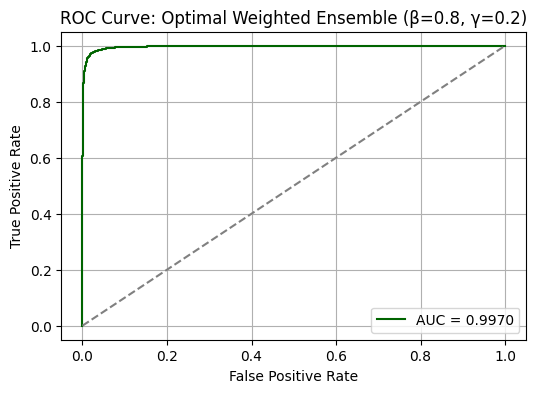

In [18]:
# === 6. Run Final Evaluation with Optimal Weights ===
evaluate_three_model_ensemble(
    model_icgan,           # already loaded earlier
    model_dcgan,           # already loaded earlier
    model_stylegan,        # just defined
    test_loader,           # already built
    alpha=0.0,
    beta=0.8,
    name="Optimal Weighted Ensemble (β=0.8, γ=0.2)"
)


# 4 model temp optimized

In [21]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# ----------------------------------------------
# 🔧 Manual Weights + Temperature
# ----------------------------------------------
USE_OPTIMIZED_WEIGHTS = False
ALPHA =0.30000000000000004
BETA = 0.5
GAMMA = 0.1
DELTA = 0.09999999999999995

USE_TEMPERATURE_SCALING = True
TEMPERATURE = 1.5

# ----------------------------------------------
# 🔍 Find best threshold for classification
# ----------------------------------------------
def find_best_threshold(labels, probs):
    best_thresh = 0.5
    best_acc = 0
    for t in np.arange(0.3, 0.71, 0.01):
        preds = (np.array(probs) >= t).astype(int)
        acc = accuracy_score(labels, preds)
        if acc > best_acc:
            best_acc = acc
            best_thresh = t
    return best_thresh

# ----------------------------------------------
# 🔧 Grid search for best ensemble weights
# ----------------------------------------------
def optimize_weights(models, loader, search_step=0.1):
    best_acc = 0
    best_weights = (0.25, 0.25, 0.25)
    for a in np.arange(0, 1 + search_step, search_step):
        for b in np.arange(0, 1 - a + search_step, search_step):
            for g in np.arange(0, 1 - a - b + search_step, search_step):
                d = 1 - a - b - g
                if d < 0: continue
                acc = evaluate_ensemble_once(*models, loader, a, b, g, silent=True)
                if acc > best_acc:
                    best_acc = acc
                    best_weights = (a, b, g)
    return best_weights

def evaluate_ensemble_once(model1, model2, model3, model4, loader,
                           alpha, beta, gamma, silent=False):
    all_labels, all_preds = [], []
    model1.eval()
    model2.eval()
    model3.eval()
    model4.eval()

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            p1 = model1(images).view(-1)
            p2 = model2(images).view(-1)
            p3 = model3(images).view(-1)
            logits = model4(images)

            if USE_TEMPERATURE_SCALING:
                logits /= TEMPERATURE
            p4 = torch.softmax(logits, dim=1)[:, 1]

            combined = (alpha * p1 + beta * p2 + gamma * p3 + (1 - alpha - beta - gamma) * p4).cpu().numpy()
            pred_labels = (combined >= 0.5).astype(int)

            all_preds.extend(pred_labels)
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    return acc

# ----------------------------------------------
# 🚀 Final ensemble evaluation
# ----------------------------------------------
def evaluate_four_model_ensemble(model1, model2, model3, model4, loader,
                                 name="ICGAN + DCGAN + StyleGAN + ResNet"):
    if USE_OPTIMIZED_WEIGHTS:
        print("🔍 Optimizing ensemble weights...")
        best_alpha, best_beta, best_gamma = optimize_weights(
            (model1, model2, model3, model4), loader, search_step=0.1
        )
        print(f"✅ Best weights found: α={best_alpha}, β={best_beta}, γ={best_gamma}, δ={1 - best_alpha - best_beta - best_gamma}")
    else:
        best_alpha, best_beta, best_gamma = ALPHA, BETA, GAMMA
        print(f"🔧 Using manual weights: α={ALPHA}, β={BETA}, γ={GAMMA}, δ={DELTA}")

    all_labels, all_probs, all_preds = [], [], []
    model1.eval()
    model2.eval()
    model3.eval()
    model4.eval()

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            p1 = model1(images).view(-1)
            p2 = model2(images).view(-1)
            p3 = model3(images).view(-1)
            logits = model4(images)

            if USE_TEMPERATURE_SCALING:
                logits /= TEMPERATURE
            p4 = torch.softmax(logits, dim=1)[:, 1]

            combined = (best_alpha * p1 + best_beta * p2 + best_gamma * p3 +
                        (1 - best_alpha - best_beta - best_gamma) * p4).cpu().numpy()

            all_probs.extend(combined)
            all_labels.extend(labels.cpu().numpy())

    # 🔍 Tune classification threshold
    best_thresh = find_best_threshold(all_labels, all_probs)
    print(f"🎯 Optimal Threshold: {best_thresh:.2f}")
    all_preds = (np.array(all_probs) >= best_thresh).astype(int)

    # 📊 Metrics
    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=["Fake", "Real"])
    auc = roc_auc_score(all_labels, all_probs)

    print(f"\n🧪 Final Evaluation for {name}")
    print(f"✅ Accuracy: {acc * 100:.2f}%")
    print(f"📊 Confusion Matrix:\n{cm}")
    print(f"📋 Classification Report:\n{cr}")
    print(f"📈 ROC-AUC Score: {auc:.4f}")

    # 📈 ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color="darkblue")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f"ROC Curve: {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

🔧 Using manual weights: α=0.30000000000000004, β=0.5, γ=0.1, δ=0.09999999999999995
🎯 Optimal Threshold: 0.50

🧪 Final Evaluation for ICGAN + DCGAN + StyleGAN + ResNet
✅ Accuracy: 97.52%
📊 Confusion Matrix:
[[9744  256]
 [ 240 9760]]
📋 Classification Report:
              precision    recall  f1-score   support

        Fake       0.98      0.97      0.98     10000
        Real       0.97      0.98      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000

📈 ROC-AUC Score: 0.9971


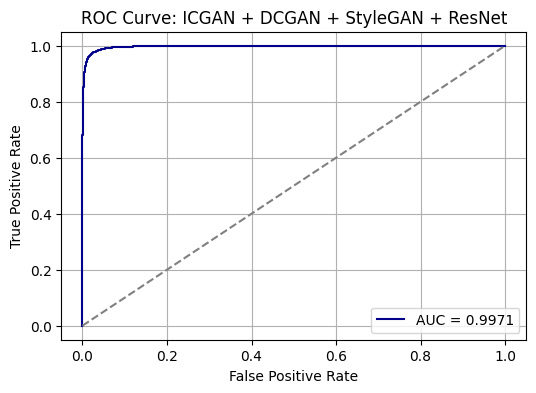

In [22]:
evaluate_four_model_ensemble( model_icgan,  model_dcgan,model_stylegan, model, test_loader)

# 3 gans + resnet temp scaled

✅ Using device: cuda
✅ StyleGAN loaded.


<ipython-input-30-41c3814d2bf7>:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw_state = torch.load(ckpt, map_location=device)


🔥 Best Temperature = 3.00 (AUC = 0.9971)

🧪 Final Evaluation for ICGAN + DCGAN + StyleGAN
✅ Accuracy: 96.47%
📊 Confusion Matrix:
[[9376  624]
 [  82 9918]]
📋 Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.94      0.96     10000
        Real       0.94      0.99      0.97     10000

    accuracy                           0.96     20000
   macro avg       0.97      0.96      0.96     20000
weighted avg       0.97      0.96      0.96     20000

📈 ROC-AUC Score: 0.9971


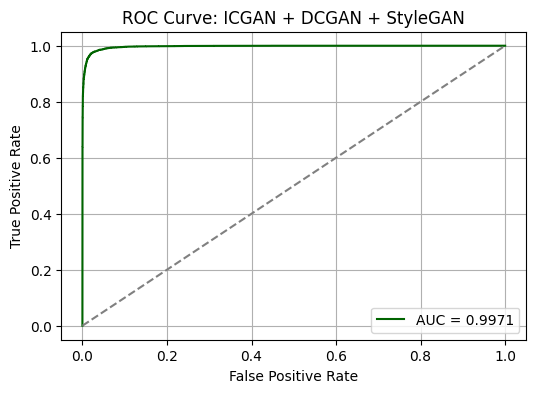

In [30]:
# === 1. Imports ===
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
)

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# === 2. Device & Reproducibility ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
print("✅ Using device:", device)

# === 3. StyleGAN Discriminator Definition ===
class EqualizedLinear(nn.Module):
    def __init__(self, in_f, out_f, gain=1.0):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_f, in_f).div_(gain))
        self.bias = nn.Parameter(torch.zeros(out_f))
    def forward(self, x):
        return F.linear(x, self.weight, self.bias)

class EqualizedConv2d(nn.Module):
    def __init__(self, in_ch, out_ch, k, stride=1, pad=0):
        super().__init__()
        conv = nn.Conv2d(in_ch, out_ch, k, stride, pad)
        scale = 1 / np.sqrt(in_ch * k * k)
        nn.init.normal_(conv.weight, 0.0, 1.0)
        conv.weight.data.mul_(scale)
        nn.init.zeros_(conv.bias)
        self.conv = conv
    def forward(self, x):
        return self.conv(x)

class MinibatchStdDev(nn.Module):
    def __init__(self, group_size=4):
        super().__init__()
        self.group_size = group_size
    def forward(self, x):
        bs, ch, h, w = x.shape
        g = min(self.group_size, bs)
        if g <= 1:
            return torch.cat([x, torch.zeros(bs, 1, h, w, device=x.device)], dim=1)
        n = bs // g
        y = x.view(g, n, ch, h, w)
        y = y.std(dim=0, unbiased=False).mean(dim=1, keepdim=True)
        y = y.repeat(g, 1, 1, 1)[:bs]
        return torch.cat([x, y], dim=1)

class StyleGANDiscriminator(nn.Module):
    def __init__(self, channels=32):
        super().__init__()
        self.from_rgb = EqualizedConv2d(3, channels, 1)
        self.features = nn.ModuleList([
            nn.Sequential(EqualizedConv2d(channels, channels*2, 4, 2, 1), nn.LeakyReLU(0.2)),
            nn.Sequential(EqualizedConv2d(channels*2, channels*4, 4, 2, 1), nn.LeakyReLU(0.2)),
            nn.Sequential(EqualizedConv2d(channels*4, channels*8, 4, 2, 1), nn.LeakyReLU(0.2)),
        ])
        self.final_block = nn.Sequential(
            MinibatchStdDev(),
            EqualizedConv2d(channels*8 + 1, channels*8, 3, 1, 1),
            nn.LeakyReLU(0.2),
            EqualizedConv2d(channels*8, channels*4, 4, 1, 0),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            EqualizedLinear(channels*4, 1)
        )
    def forward(self, x):
        x = self.from_rgb(x)
        for block in self.features:
            x = block(x)
        return self.final_block(x).view(-1)

# === 4. StyleGAN Load Checkpoint ===
model_stylegan = StyleGANDiscriminator().to(device)
ckpt = "/kaggle/input/finetunedgans/finetuned_stylegan_discriminator_cifake.pth"
raw_state = torch.load(ckpt, map_location=device)
fixed_state = {}
for k, v in raw_state.items():
    if k.startswith("final_block.6.linear"):
        fixed_state[k.replace("final_block.6.linear", "final_block.6")] = v
    else:
        fixed_state[k] = v
model_stylegan.load_state_dict(fixed_state, strict=False)
print("✅ StyleGAN loaded.")
model_stylegan.eval()

# === 5. Optimize Temperature ===
def optimize_temperature(model1, model2, model3, loader, alpha, beta, gamma):
    best_temp = 1.0
    best_auc = 0.0
    for temp in np.arange(0.5, 3.05, 0.1):
        all_labels, all_probs = [], []
        with torch.no_grad():
            for images, labels in loader:
                images = images.to(device)
                labels = labels.to(device)
                p1 = torch.sigmoid(model1(images).view(-1) / temp)
                p2 = torch.sigmoid(model2(images).view(-1) / temp)
                p3 = torch.sigmoid(model3(images).view(-1) / temp)
                combined = (alpha * p1 + beta * p2 + gamma * p3).cpu().numpy()
                all_probs.extend(combined)
                all_labels.extend(labels.cpu().numpy())
        auc = roc_auc_score(all_labels, all_probs)
        if auc > best_auc:
            best_auc = auc
            best_temp = temp
    print(f"🔥 Best Temperature = {best_temp:.2f} (AUC = {best_auc:.4f})")
    return best_temp

# === 6. Final 3-model Ensemble Evaluation Function ===
def evaluate_three_model_ensemble(model1, model2, model3, loader, alpha=0.26, beta=0.27, name="ICGAN + DCGAN + StyleGAN"):
    gamma = 1 - alpha - beta
    temperature = optimize_temperature(model1, model2, model3, loader, alpha, beta, gamma)

    all_labels, all_probs, all_preds = [], [], []
    model1.eval()
    model2.eval()
    model3.eval()

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            p1 = torch.sigmoid(model1(images).view(-1) / temperature)
            p2 = torch.sigmoid(model2(images).view(-1) / temperature)
            p3 = torch.sigmoid(model3(images).view(-1) / temperature)
            combined = (alpha * p1 + beta * p2 + gamma * p3).cpu().numpy()
            pred_labels = (combined >= 0.5).astype(int)
            all_probs.extend(combined)
            all_preds.extend(pred_labels)
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=["Fake", "Real"])
    auc = roc_auc_score(all_labels, all_probs)

    print(f"\n🧪 Final Evaluation for {name}")
    print(f"✅ Accuracy: {acc * 100:.2f}%")
    print(f"📊 Confusion Matrix:\n{cm}")
    print(f"📋 Classification Report:\n{cr}")
    print(f"📈 ROC-AUC Score: {auc:.4f}")

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color="darkgreen")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f"ROC Curve: {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

# === 7. Run Final Evaluation ===
evaluate_three_model_ensemble(
    model_icgan,         # already loaded earlier
    model_dcgan,         # already loaded earlier
    model_stylegan,      # just defined
    test_loader,         # already built
    alpha=0,
    beta=0.8,
    name="ICGAN + DCGAN + StyleGAN"
)

✅ Using best weights: α=0.00, β=0.80, γ=0.20
🌡 Temperature scaling: ON

🧪 Final Evaluation for ICGAN + DCGAN + StyleGAN
✅ Accuracy: 95.88%
📊 Confusion Matrix:
[[9241  759]
 [  66 9934]]
📋 Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.92      0.96     10000
        Real       0.93      0.99      0.96     10000

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000

📈 ROC-AUC Score: 0.9969


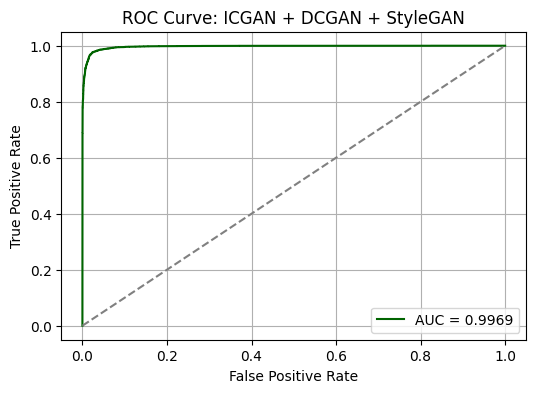

In [28]:
evaluate_three_model_ensemble( model_icgan,  model_dcgan,model_stylegan, test_loader)

# 3 gans temp scaled

In [32]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# ----------------------------------------------
# 🔧 Manual Weights + Temperature
# ----------------------------------------------
USE_OPTIMIZED_WEIGHTS = False
ALPHA =0.30000000000000004
BETA = 0.5
GAMMA = 0.1
DELTA = 0.09999999999999995

USE_TEMPERATURE_SCALING = True
TEMPERATURE = 1.5

# ----------------------------------------------
# 🔍 Find best threshold for classification
# ----------------------------------------------
def find_best_threshold(labels, probs):
    best_thresh = 0.5
    best_acc = 0
    for t in np.arange(0.3, 0.71, 0.01):
        preds = (np.array(probs) >= t).astype(int)
        acc = accuracy_score(labels, preds)
        if acc > best_acc:
            best_acc = acc
            best_thresh = t
    return best_thresh

# ----------------------------------------------
# 🔧 Grid search for best ensemble weights
# ----------------------------------------------
def optimize_weights(models, loader, search_step=0.1):
    best_acc = 0
    best_weights = (0.25, 0.25, 0.25)
    for a in np.arange(0, 1 + search_step, search_step):
        for b in np.arange(0, 1 - a + search_step, search_step):
            for g in np.arange(0, 1 - a - b + search_step, search_step):
                d = 1 - a - b - g
                if d < 0: continue
                acc = evaluate_ensemble_once(*models, loader, a, b, g, silent=True)
                if acc > best_acc:
                    best_acc = acc
                    best_weights = (a, b, g)
    return best_weights

def evaluate_ensemble_once(model1, model2, model3, loader,
                           alpha, beta, gamma, silent=False):
    all_labels, all_preds = [], []
    model1.eval()
    model2.eval()
    model3.eval()

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            p1 = model1(images).view(-1)
            p2 = model2(images).view(-1)
            p3 = model3(images).view(-1)
           
            combined = (alpha * p1 + beta * p2 + gamma * p3 ).cpu().numpy()
            pred_labels = (combined >= 0.5).astype(int)

            all_preds.extend(pred_labels)
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    return acc

# ----------------------------------------------
# 🚀 Final ensemble evaluation
# ----------------------------------------------
def evaluate_four_model_ensemble(model1, model2, model3, loader,
                                 name="ICGAN + DCGAN + StyleGAN "):
    if USE_OPTIMIZED_WEIGHTS:
        print("🔍 Optimizing ensemble weights...")
        best_alpha, best_beta, best_gamma = optimize_weights(
            (model1, model2, model3), loader, search_step=0.1
        )
        print(f"✅ Best weights found: α={best_alpha}, β={best_beta}, γ={best_gamma}, δ={1 - best_alpha - best_beta - best_gamma}")
    else:
        best_alpha, best_beta, best_gamma = ALPHA, BETA, GAMMA
        print(f"🔧 Using manual weights: α={ALPHA}, β={BETA}, γ={GAMMA}, δ={DELTA}")

    all_labels, all_probs, all_preds = [], [], []
    model1.eval()
    model2.eval()
    model3.eval()

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            p1 = model1(images).view(-1)
            p2 = model2(images).view(-1)
            p3 = model3(images).view(-1)
           
            combined = (best_alpha * p1 + best_beta * p2 + best_gamma * p3).cpu().numpy()

            all_probs.extend(combined)
            all_labels.extend(labels.cpu().numpy())

    # 🔍 Tune classification threshold
    best_thresh = find_best_threshold(all_labels, all_probs)
    print(f"🎯 Optimal Threshold: {best_thresh:.2f}")
    all_preds = (np.array(all_probs) >= best_thresh).astype(int)

    # 📊 Metrics
    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=["Fake", "Real"])
    auc = roc_auc_score(all_labels, all_probs)

    print(f"\n🧪 Final Evaluation for {name}")
    print(f"✅ Accuracy: {acc * 100:.2f}%")
    print(f"📊 Confusion Matrix:\n{cm}")
    print(f"📋 Classification Report:\n{cr}")
    print(f"📈 ROC-AUC Score: {auc:.4f}")

    # 📈 ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color="darkblue")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f"ROC Curve: {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

🔧 Using manual weights: α=0.30000000000000004, β=0.5, γ=0.1, δ=0.09999999999999995
🎯 Optimal Threshold: 0.43

🧪 Final Evaluation for ICGAN + DCGAN + StyleGAN 
✅ Accuracy: 97.56%
📊 Confusion Matrix:
[[9752  248]
 [ 241 9759]]
📋 Classification Report:
              precision    recall  f1-score   support

        Fake       0.98      0.98      0.98     10000
        Real       0.98      0.98      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000

📈 ROC-AUC Score: 0.9971


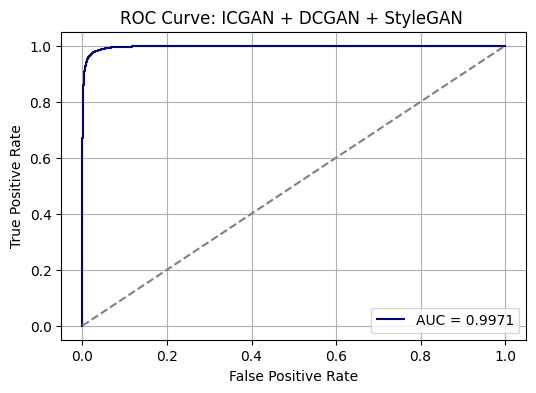

In [33]:
evaluate_four_model_ensemble( model_icgan,  model_dcgan,model_stylegan, test_loader)